# WGCNA using parameters

Below is some demonstration data, that takes the parameters for each individual fitted from a common negative binomial model (meaning they all have the same dispersion parameter). This can be probably to expression data directly. This notebook will be a tutorial about how to identify gene modules (where they can be identified).

In [ ]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../src")
df = pd.read_csv("../data/data.csv").set_index("specimen").drop("group", axis=1).T

# To remove those with too small of values
df = df.loc[df.min(axis=1) > -10]

In [97]:
import topology
import activation
import clustering
import correlation
import utilities

import importlib
importlib.reload(topology)
importlib.reload(utilities)
importlib.reload(activation)
importlib.reload(clustering)
importlib.reload(correlation)

<module 'correlation' from '/Users/jameshaberberger/GitHub/pywgcna/example/../src/correlation.py'>

Here, we compute the shrunk covariance matrix using the Ledoit-Wolf estimator, find the scale free power, and compute the Topological Overlap Matrix (measure of graph similarity).

In [159]:
corr = correlation.compute_shrunk_correlation(df.T)

sf_power = topology.find_scale_free_power(
    activation.strictly_positive_activation(corr)
)

TOM = pd.DataFrame(
    topology.topological_overlap(np.power(activation.strictly_positive_activation(corr), sf_power)),
    index=df.index,
    columns=df.index
)

Power: 1, R^2: 0.16026281312026605
Power: 2, R^2: 0.7896350486515918
Power: 3, R^2: 0.9614165999310181


<Axes: ylabel='Frequency'>

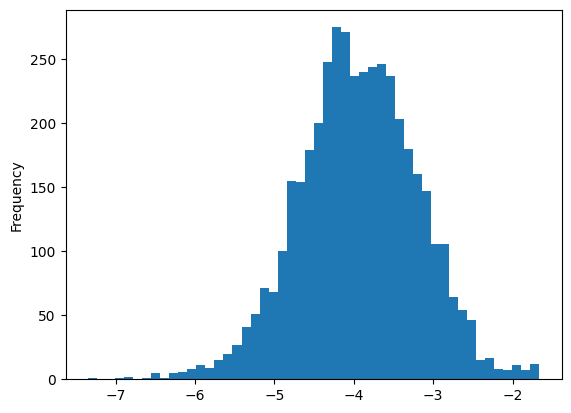

In [160]:
import sklearn.mixture

identifying_spurious_correlations = pd.DataFrame({
    "group": sklearn.mixture.GaussianMixture(n_components=2).fit_predict(pd.Series(TOM.max(axis=0), index=df.index).apply(np.log).values.reshape(-1, 1)).tolist(),
    "max_log_corr": pd.Series(TOM.max(axis=0), index=df.index).apply(np.log)
})

identifying_spurious_correlations["max_log_corr"].plot.hist(bins=50)

In [165]:
spurious_correlations = pd.Series(TOM.max(axis=0), index=df.index).apply(np.log).between(-2.5, -1)

TOM = TOM.loc[spurious_correlations, spurious_correlations]

In [166]:
labels = clustering.spectral_clustering_method(TOM)

100%|██████████| 19/19 [00:00<00:00, 185.47it/s]

2 61.9217235856892
3 57.818324774866525
4 74.7319898762627
5 98.47012909262601
6 76.36392796169524
7 63.24389533133332
8 56.9341043119486
9 47.25916366755144
10 51.27982711267666
11 48.04933619490921
12 45.73649172072688
13 39.39525233203954
14 35.668030039152114
15 35.56141186295319
16 33.26880426780654
17 31.8768462671633
18 30.994941293249646
19 27.10931035235642
20 27.00186171902103
Optimal number of clusters: 5 with Calinski-Harabasz score: 98.47012909262601


In [167]:
pd.Series(labels).value_counts()

1    35
2    21
3    12
4    10
0    10
Name: count, dtype: int64

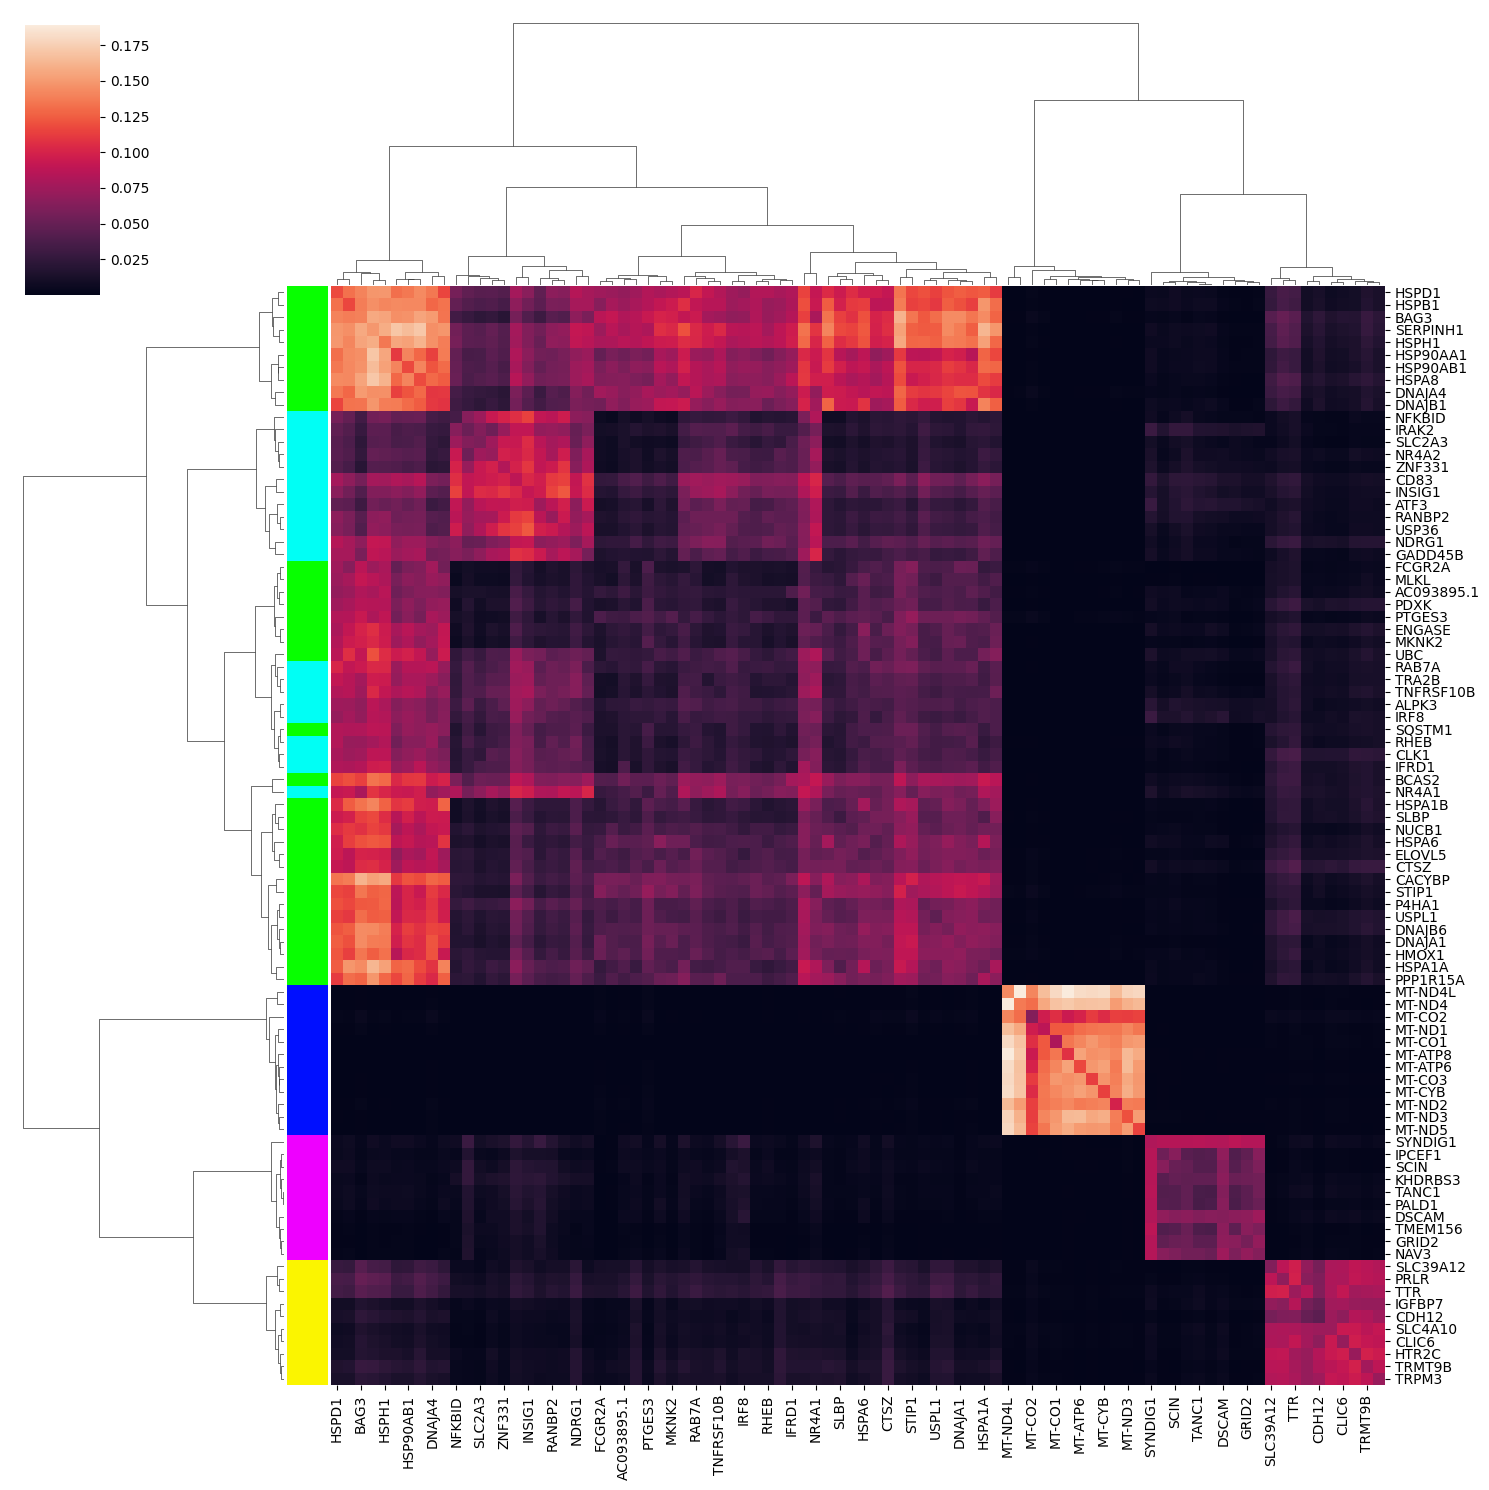

In [168]:
sns.clustermap(
    TOM,
    yticklabels=True,
    figsize=(15, 15),
    row_colors=utilities.labels_to_hex_colors(labels),
    method="ward"
)